# Preamble

This notebook was presented to the CSIRO Climate Variability and Hazards group, along with additional contributors to the Australian Climate Service (ACS) from CSIRO and the BoM on 21/09/2023.

To run this notebook, you will need to be a member of the following Gadi projects:
- `oi10`

In [1]:
import warnings
warnings.filterwarnings("ignore") # Don't do this outside of this demo

# The ACCESS-NRI Intake catalog

- A Python tool for discovering, loading and sharing data without having to where they are or how they are structured
- Uses the [Intake Python package](https://intake.readthedocs.io)
- Read the documentation [here](https://access-nri-intake-catalog.readthedocs.io/en/latest/index.html)

<img src="assets/Intake_black_box.svg" alt="Alternative text" width="450" />

# Loading the catalog

Loading the catalog is a easy as

In [2]:
import intake

catalog = intake.cat.access_nri

With that, we can now discover and load ~3 PB of data on Gadi without leaving this notebook. Each entry in the table below corresponds to a different data "product". For flexibility, we are deliberately vague about what a data product is. It could be the outputs from a particular model run, or it could be an entire CMIP collection. In ACS, these might be different downscaling runs, for example.

In [3]:
catalog

,model,description,realm,frequency,variable
name,,,,,
01deg_jra55v13_ryf9091,{ACCESS-OM2},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{seaIce, ocean}","{fx, 3mon, 1mon, 3hr, 1day}","{Tsfc_m, ULAT, passive_weddell, fprec, sea_level, uvel_m, usurf, pot_temp, wfimelt, TLAT, sst_m, area_u, lprec, opening_m, ty_trans_nrho_submeso, total_ocean_hflux_coupler, mld, frazil_3d_int_z, u..."
01deg_jra55v140_iaf,{ACCESS-OM2},{Cycle 1/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{1mon, fx, 1day}","{Tsfc_m, ULAT, uvel, dvidtt, fprec, diff_cbt_t, sea_level, snoice, uvel_m, hi, snoice_m, pot_temp, wfimelt, TLAT, vicen, area_u, lprec, opening_m, ty_trans_nrho_submeso, total_ocean_hflux_coupler,..."
01deg_jra55v140_iaf_cycle2,{ACCESS-OM2},{Cycle 2/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{1mon, fx, 1day}","{Tsfc_m, ULAT, uvel, dvidtt, fprec, diff_cbt_t, sea_level, snoice, usurf, VGRDi, uvel_m, hi, snoice_m, pot_temp, wfimelt, TLAT, vicen, area_u, lprec, opening_m, ty_trans_nrho_submeso, total_ocean_..."
01deg_jra55v140_iaf_cycle3,{ACCESS-OM2},{Cycle 3/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{1mon, fx, 1day}","{Tsfc_m, ULAT, uvel, dvidtt, fprec, diff_cbt_t, sea_level, snoice, usurf, VGRDi, uvel_m, hi, snoice_m, pot_temp, wfimelt, TLAT, area_u, lprec, opening_m, ty_trans_nrho_submeso, total_ocean_hflux_c..."
01deg_jra55v140_iaf_cycle4,{ACCESS-OM2},{Cycle 4/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{fx, 6hr, 1mon, 3hr, 1day}","{PP_net, ULAT, uvel, dvidtt, surface_o2, snoice, VGRDi, usurf, surface_dic, meltl_m, pprod_gross_2d, area_u, fe_zflux_adv, opening_m, mld, caco3_xflux_adv, hu, surface_det, src05, total_ocean_swfl..."
01deg_jra55v140_iaf_cycle4_jra55v150_extension,{ACCESS-OM2},{Extensions of cycle 4/4 of 0.1 degree ACCESS-OM2 + WOMBAT BGC global model configuration with JRA55-do v1.5.0 and v1.5.0.1 OMIP2 interannual forcing},"{seaIce, ocean}","{1mon, 0hr, fx, 1day}","{phy_int100, Tsfc_m, npp1, PP_net, uvel, ULAT, dvidtt, fprec, surface_o2, diff_cbt_t, no3_xflux_adv, surface_zoo, sea_level, snoice, usurf, uvel_m, hi, surface_dic, pot_temp, snoice_m, radbio3d, f..."
01deg_jra55v150_iaf_cycle1,{ACCESS-OM2},{Cycle 1/1 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do \nv1.5.0 OMIP2 interannual forcing},"{seaIce, ocean}","{1mon, fx, 1day}","{ULAT, fprec, diff_cbt_t, sea_level, wfimelt, TLAT, area_u, lprec, ty_trans_nrho_submeso, mld, frazil_3d_int_z, hu, eta_nonbouss, aice_m, geolat_t, temp_int_rhodz, average_DT, sfc_salt_flux_restor..."
025deg_jra55_iaf_omip2_cycle1,{ACCESS-OM2},{Cycle 1/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},"{seaIce, ocean}","{1mon, 1yr, fx, 1day}","{temp_vdiffuse_k33, salt_advection, Tsfc_m, ULAT, uvel, dvidtt, mld_sq, fprec, diff_cbt_t, ice_present_m, aredi, neutral_gm_temp, sea_level, snoice, usurf, uvel_m, hi, total_mass_seawater, pot_tem..."
025deg_jra55_iaf_omip2_cycle2,{ACCESS-OM2},{Cycle 1/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},"{seaIce, ocean}","{1mon, 1yr, fx, 1day}","{temp_vdiffuse_k33, salt_advection, Tsfc_m, ULAT, uvel, dvidtt, mld_sq, fprec, diff_cbt_t, ice_present_m, aredi, neutral_gm_temp, sea_level, snoice, usurf, uvel_m, hi, total_mass_seawater, pot_tem..."


# Filtering products and data discovery

We can search on the columns in the catalog. For example, below we search for all products that contain variables starting with the letter "o" at daily frequency. The `search` method returns another catalog object with entries that satisfy our search criteria.

In [4]:
catalog_filtered = catalog.search(frequency="1day", variable="o.*")

catalog_filtered

,model,description,realm,frequency,variable
name,,,,,
01deg_jra55v140_iaf_cycle4,{ACCESS-OM2},{Cycle 4/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},{ocean},{1day},"{o2, o2_int100, o2_intmld}"
01deg_jra55v140_iaf_cycle4_jra55v150_extension,{ACCESS-OM2},{Extensions of cycle 4/4 of 0.1 degree ACCESS-OM2 + WOMBAT BGC global model configuration with JRA55-do v1.5.0 and v1.5.0.1 OMIP2 interannual forcing},{ocean},{1day},"{o2, o2_int100, o2_intmld}"
cmip5_al33,"{IPSL-CM5A-LR, MPI-ESM-P, inmcm4, FGOALS-g2, CanESM2, MPI-ESM-LR, NorESM1-M, MPI-ESM-MR}",{Replicated CMIP5-era datasets catalogued by NCI},{ocean},{1day},{omldamax}
cmip5_rr3,"{ACCESS1-3, ACCESS1-0}",{Australian CMIP5-era datasets catalogued by NCI},{ocean},{1day},{omldamax}
cmip6_fs38,{ACCESS-ESM1-5},{Australian CMIP6-era datasets catalogued by NCI},{ocean},{1day},{omldamax}
cmip6_oi10,"{EC-Earth3-Veg, HadGEM3-GC31-LL, EC-Earth3, MRI-ESM2-0, CanESM5, IPSL-CM6A-LR}",{Replicated CMIP6-era datasets catalogued by NCI},"{aerosol, ocean}",{1day},"{od550aer, omldamax}"


# Getting data from products

Each product comprises many (up to millions) of files that make up many (up to hundreds of thousands) of datasets. We typically only want to open a few of these. Once you've found the product(s) you want, you can load metadata tables (these are actually called [Intake-ESM datastores](https://intake-esm.readthedocs.io/en/stable/)) for each product to help you find and load the datasets you're after.

Here we'll show the simplest case of loading the metadata table of a product you already know the name of, but you can also load mutliple product metadata tables at the same time from your filtered catalog. 

In [5]:
cmip6_datastore = catalog.cmip6_oi10

Similar to our search on the catalog, we can filter by the product metadata for datasets that interest us.

In [6]:
cmip6_datastore_filtered = cmip6_datastore.search(
    experiment_id=["historical", "ssp245"],
    source_id=["EC-Earth3", "MIROC6", "NorESM2-LM", "NorESM2-MM"],
    variable_id="tos",
    frequency="mon",
    member_id="r1i1p1f1",
)

Now we can load the datasets for our analysis.

In [7]:
from distributed import Client

client = Client(threads_per_worker=1)
client.dashboard_link

'/proxy/8787/status'

In [8]:
# Some arguments to make the loading easier/faster
xarray_open_kwargs = dict(use_cftime=True)
xarray_combine_by_coords_kwargs = dict(
        compat="override",
        data_vars="minimal", 
        coords="minimal",
    )

dataset_dict = cmip6_datastore_filtered.to_dataset_dict(
    progressbar=False,
    xarray_open_kwargs=xarray_open_kwargs,
    xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs,
)

To do our analyses we'll use xarray-datatree to (hopefully) demonstrate how easy this makes multi-model analyses. Our "analysis" here is just to plot timeseries of the (unweighted) global mean. (Note, the demo here is based of [this blog](https://medium.com/pangeo/easy-ipcc-part-1-multi-model-datatree-469b87cf9114)).

In [9]:
from datatree import DataTree, map_over_subtree
from xmip.preprocessing import rename_cmip6
import matplotlib.pyplot as plt

In [10]:
dt = DataTree.from_dict(
    {f"{name.split('.')[3]}/{name.split('.')[4]}": rename_cmip6(ds) for name, ds in dataset_dict.items()}, 
)

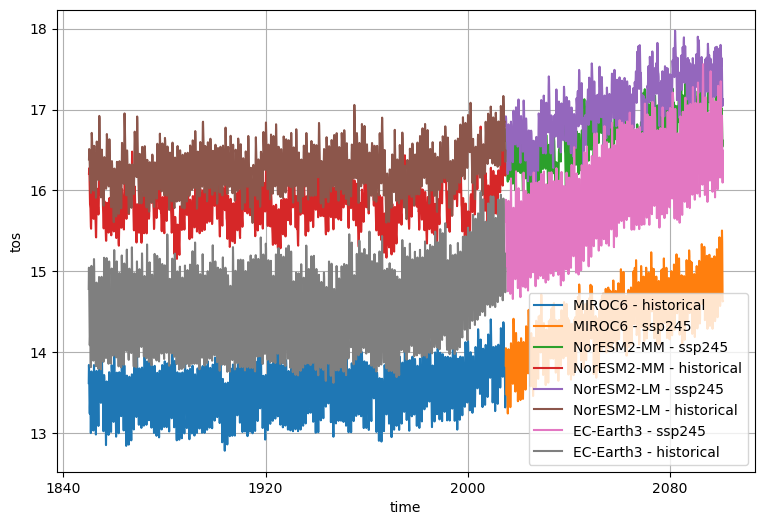

In [11]:
fig, ax = plt.subplots(figsize=(9,6))

@map_over_subtree
def plot_global_mean(ds):
    label = f'{ds.attrs["source_id"]} - {ds.attrs["experiment_id"]}'
    ds["tos"].mean(["x", "y"]).plot(ax=ax, label=label)
    return ds

plot_global_mean(dt)
ax.legend()
ax.grid()

In [12]:
client.close()